Estimation Example
======
***
The goal of this notebook is to try different estimation techniques on a given simulated data with added white noise. In this particular exercise we will try to estimate the parameters of a Point Spread Function (PSF). 

The three techniques to try would be the *Least Mean Squares*, *Maximum-likelihood*, and *Bayesian estimation*.  This is based on an exercise given by Professor [H. Carfantan ](http://userpages.irap.omp.eu/~hcarfantan/ "H. Carfantan Homepage")at IRAP as part of the Master 2 Recherche Astrophysique, Sciences de l'Espace et Planétologie [(ASEP).](http://ezomp2.omp.obs-mip.fr/asep/)

## The Model:
***

The Moffat distribution is widely used in astrophysics. It is given by the expression: 

\begin{align}
PSF(l,c) = \left ( 1 + \frac{l^2+c^2}{\alpha ^2} \right ) ^{-\beta}
\end{align}

where $l_0$ corresponds to the rows, and $l_0$ to the columns in an image. It also depends on $\alpha$ and $\beta$. $\alpha >0 $ represents the amplitude parameter and $\beta > 1$ the shape.    

With the moffat distribution as our PSF we are going to simulate an observation of a star at position $(l_0, c_0)$, amplitude $a$, and a sky background $s$. The model is express as:


$$d(l,c) = s + a \cdot \text{PSF}(l-l_0, c -c_0) + b(l,c)$$


where $b(l,c)$ represents the added white noise to the system. We assume noise given by a Gaussian distribution  with 0 mean and variance $\sigma ^2$. 


This will represent our data set on which we will perform our analysis.

We generate the data with the model and the added noise. For this we first import the necessary packages:

In [2]:
#Import needed packages:
from astropy.modeling import models, fitting
import scipy.optimize
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from IPython.display import Latex

Then we decide on our parameters, generate the data and plot:

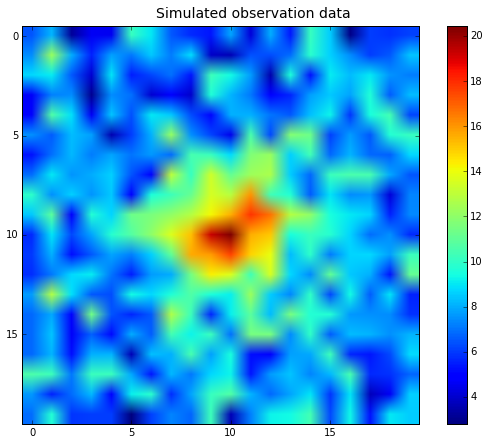

In [3]:
#------------#
#-Parameters:
#------------#
#Grid
L= 20 ; C = 20;
Col, Lig = np.mgrid[:C, :L]
#Moffat
a=1; l0 =10; c0=10; beta = 2; alphaa =4;
#Noise Gaussian
sigma=2 #Standard Deviation
noise = np.random.normal(0, sigma, Col.shape)
#Sky
s=6.8
#amplitude star
amp=12.54

#------#
#data
#------#
# Generate PSF with astropy.modeling
#g = models.Moffat2D(amplitude=a, x_0=l0, y_0=c0, gamma=gamma, alpha=alpha)
g = models.Moffat2D.evaluate(Col,Lig,amplitude=a, x_0=c0, y_0=l0, gamma=alphaa, alpha=beta)

#Generate Data model to Use
data = s + amp * g + noise
# Plot the data:
%matplotlib inline
plt.figure(figsize=(8,6))
plt.imshow(data)
plt.colorbar()
plt.suptitle("Simulated observation data",
             y=1.02,
             fontsize=14)
plt.tight_layout()

We will work with vector so we want to make a distinction between the column vector d, and the square matrix  data. This will be useful later.

In [4]:
#Data in one dimension
d = np.ravel(data) #from top to bottom. The first 20 element are c_(0-N) and l0.
#Model one dimension
gmodel= np.ravel(g)

## Estimating the amplitude and sky background
***

We first assume that we know the position $(l_0, c_0)$ and the parameters $\alpha$ and $\beta$ of the PSF. We define a vector parameter $\theta = [s, a]^{\text T}$ and can express our model in matrix form:

 $$d =  H \cdot  \theta +  \mathcal N(0, \sigma^2)$$


 
 \begin{equation}
 \left[ \begin{array}{c} d_{1}  \\ d_{2} \\ ...  \end{array} \right ] =   \left[ \begin{array}{cc} 1 &  PSF(l_1, c_1) \\ 1 & PSF(l_2,c_2) \\ ...  \end{array} \right ] \cdot \left[ \begin{array}{c} s  \\ a   \end{array} \right ] + \mathcal{N}(0,\sigma^2)
 \end{equation}
 
 #### The Likelihood:
 
 In this case with additive Gaussian noise $\mathcal N(0,\sigma^2$) the likelihood takes the form:
 
 $$ L(\theta;d) = f_{d|\theta} (d|\theta) = \frac{1}{\sqrt{2 \pi \sigma^2}} = exp \left ( -\frac{1}{2} (d -  H \theta)^ \text T \sigma^2 (d - H \theta )       \right)$$
 
This is the criteria we try to maximise or alternative we can minimize the negative of the logarithm of the likelihood. So our estimate of the parameters $\mathring \theta$ is:

$$\mathring \theta = arg \, max \, L(\theta ; d) = arg \, min \,  NLL(\theta; d) $$

We see that this reduces to the *Least Mean Square* method. We have an explicit equation:

$$\mathring \theta = (H ^ \text T H)^{-1} H ^ \text T d$$

With matrices in python this can can be done the following way:

In [5]:
#We create H:
H = np.vstack([np.ones(len(d)), gmodel]).T
matrixH = np.matrix(H)
temp= (matrixH.T*matrixH)**(-1)* matrixH.T 
np.dot(temp, d)

matrix([[  7.07055825,  11.31997413]])

The first one represents the estimated value of the amplitude of the star and the second the estimated value of the sky. We can get the same answer using the least mean square fit. We can use two packages. Numpy and statsmodel

In [6]:
#With stats model:
mod_wls = sm.WLS(d, H)
res = mod_wls.fit()
#print(res.summary())
print res.params[1] , res.params[0]
#With numpy
sfit, afit = np.linalg.lstsq(H, d)[0]
print afit, sfit
print("Real data values are: %.2f for amplitude and %.2f for sky background" % (amp, s ))

11.3199741311 7.07055824539
11.3199741311 7.07055824539
Real data values are: 12.54 for amplitude and 6.80 for sky background


We also can find the covariance matrix:

In [7]:
cov=(matrixH.T * matrixH)**(-1)
sigmas=np.sqrt(np.diagonal(cov))
print("sigma for a = %.4f and sigma fo s = %.4f" % (sigmas[1], sigmas[0] ))

sigma for a = 0.2913 and sigma fo s = 0.0596


# Maximum-likelihood estimation (MLE)

Now we consider the estimation of the other parameters of the star. We introduced the new vector with the parameters $\nu = [l_0, c_0, \alpha, \beta]^\text T$. Now the matrix H depends on the parameters $\nu$ and need to be determined simultaneaously with $\theta$.

$$d =  H(\nu) \cdot  \theta +  \mathcal N(0, \sigma^2)$$


 
 \begin{equation}
 \left[ \begin{array}{c} d_{1}  \\ d_{2} \\ ...  \end{array} \right ] =   \left[ \begin{array}{cc} 1 &  PSF(l_1, c_1, \alpha, \beta) \\ 1 & PSF(l_2,c_2, \alpha, \beta) \\ ...  \end{array} \right ] \cdot \left[ \begin{array}{c} s  \\ a   \end{array} \right ] + \mathcal{N}(0,\sigma^2)
 \end{equation}
 
 Now we dont have an explicit equation and now we are faced with an optimization problem. We need to minimze the NNL. From the equation of the likelihood above leaving the constants out the criteria to minimize  is given by:
 
 $$  (d -  H(\nu) \,  \theta)^ \text T  (d - H(\nu) \, \theta )  $$
 
 This is the data minus the model. We can define this function and use scipy function *optimize.minimize* to minimize it. 

In [8]:
#Define the function to minimize
from numpy import linalg as LA
def like(param):
##Know parameters:
    #Moffat
    L= 20 ; C = 20;
    Col, Lig = np.mgrid[:C, :L]
#Parameters to Estimate:
#[l0, c0, alpha, beta, a, s] 
    dd = models.Moffat2D.evaluate(Col,Lig,amplitude=param[4], x_0=param[1], y_0=param[0], gamma=param[2], alpha=param[3])
    gmodel2= np.ravel(dd)
    result = (d - (param[5] + gmodel2 )) #**2
    result = LA.norm(result)**2    #np.sum
    return result

#Initial Condition:
p0 = np.array([8,12,3,5,10,5])
p0 = np.array([10,10,1,1,0,0])

xopt = scipy.optimize.minimize(like, p0, method="L-BFGS-B" )# ,bounds=((1,20),(1,20),(0,5),(0,5),(1,15),(1,10)) )  #, # options={"maxcor": 100} )

#print "Initial Conditions of C0= %d,  L0= %d , alpha=%d, beta=%d, amp=%d , sky = %d" %(p0[0] , p0[1], p0[2], p0[3], p0[4],p0[5]  ) 
print "Real values: C0= %d,  L0= %d , alpha=%d, beta=%d, amp=%d , sky = %d" %(l0 , c0, alphaa, beta, amp , s)
print "optimization values C0= %.2f,  L0= %.2f , alpha=%.2f, beta=%.2f, amp=%.2f , sky = %.2f" %(xopt.x[0], xopt.x[1],xopt.x[2],xopt.x[3],xopt.x[4],xopt.x[5]  )

Real values: C0= 10,  L0= 10 , alpha=4, beta=2, amp=12 , sky = 6
optimization values C0= 9.99,  L0= 9.88 , alpha=3.63, beta=1.85, amp=11.79 , sky = 7.09


We can plot the results:

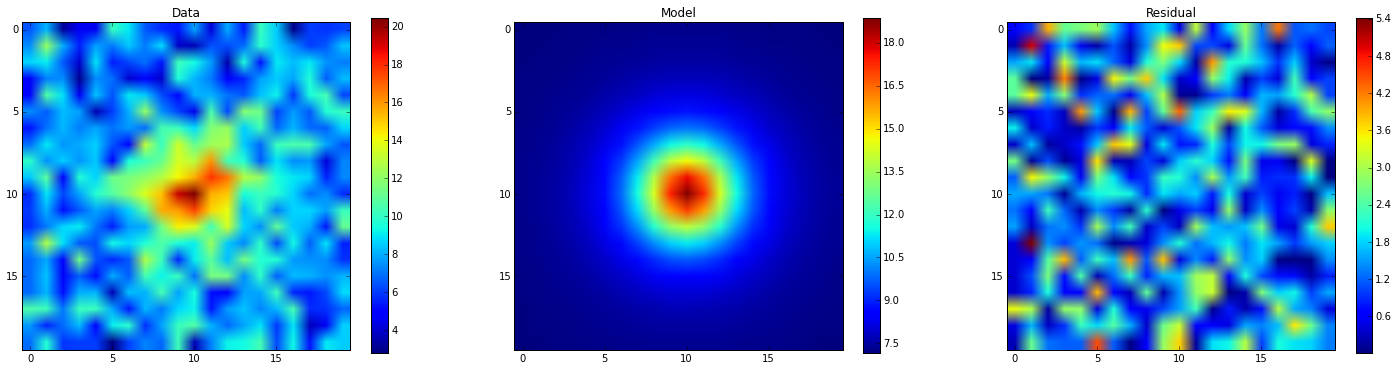

In [36]:
#Model with values of sky and amplitude found:
gfitopt = xopt.x[5] + models.Moffat2D.evaluate(Col,Lig,amplitude=xopt.x[4], x_0=xopt.x[1], y_0=xopt.x[0], gamma=xopt.x[2], alpha=xopt.x[3])
# Plot the data with the best-fit model
%matplotlib inline
plt.figure(figsize=(25,6))
plt.subplot(1,3,1)
plt.imshow(data)
plt.colorbar()
plt.title("Data")
plt.subplot(1,3,2)
plt.imshow(gfitopt)
plt.colorbar()
plt.title("Model")
plt.subplot(1,3,3)
plt.imshow(np.abs(- data + gfitopt))
plt.colorbar()
plt.title("Residual")
plt.show()

# Bayesian Estimation

We will try to estimate the parameters using a Markov chain Monte Carlo (MCMC) method. Specifically a *Metropolis-Hastings* algorithm. We will create a set of $\{p^{(k)}\}_{k=1...K}$ parameters and estimate the parameters with the obtained prior distribution by:

$$\mathring p = \frac{1}{K} \sum^K _{k=1} p^{(k)}$$

The steps for the algorithm are the following:

1.   Generate initial parameters according to a prior distribution $p^{(0)}$.
+   Generate new guess parameters $p'$ according to a proposal distribution. 
+ Generate a random normally distributed number $u$ between [0, 1].
\begin{equation}
p^{(k)}=
\begin{cases}
    p'   ,& \text{if } u < \frac{f(p') Q(p^{(k-1)};p') }{f(p^{(k-1)}) Q(p';p^{(k-1)}) } \\
    p^{(k-1)},              & \text{otherwise}
\end{cases}
\end{equation}
+ Repeat for $k=1...K$.


If we consider a symmetric proposal  distribution like a Gaussian the ratio simplifies since $Q(p^{(k-1)};p') = Q(p';p^{(k-1)})$. We will assume $Q(\cdot ; p^{(k-1)}) = \mathcal N (p ; \delta )$. We will choose a $\delta$ so that we get an acceptance rate $\sim 20 \%$.


It is easier to work with logarithms and the criteria for selection simplifies to:

$$log(u)  < \log(f(p'|d)) - \log(f(p^{(k-1)}| d )) $$

In [56]:
from scipy import stats
def priorlog(p):
    l0priorlog = stats.uniform.logpdf(p[0],0,20)
    c0priorlog = stats.uniform.logpdf(p[1],0,24)
    alphapriorlog = stats.uniform.logpdf(p[2],5,15)
    betapriorlog = stats.uniform.logpdf(p[3],5,15)
    apriorlog = stats.uniform.logpdf(p[4],0,1000)
    spriorlog = stats.uniform.logpdf(p[5],1.001,10000)
    return l0priorlog + c0priorlog + alphapriorlog + betapriorlog + apriorlog + spriorlog 

#Initialize
nrep = 1050000
nb = 5000
params=np.ones((nrep,6))
params[0] = [10,10,10,10,10,10]
sigmamcmc = .1
numaccept = 0

#Start loop
for i in range(nrep-1):
    u = np.random.rand()
    paramstemp = [np.random.normal(params[i,0], sigmamcmc, 1)[0]
                 ,np.random.normal(params[i,1], sigmamcmc, 1)[0]
                 ,np.random.normal(params[i,2], sigmamcmc, 1)[0]
                 ,np.random.normal(params[i,3], sigmamcmc, 1)[0]
                 ,np.random.normal(params[i,4], sigmamcmc, 1)[0]
                 ,np.random.normal(params[i,5], sigmamcmc, 1)[0]]
    
    posteriorlogold = - like(params[i]) +priorlog(params[i])
    posteriorlognew = - like(paramstemp) + priorlog(paramstemp)
 
    if np.log(u) < (posteriorlognew - posteriorlogold):
        params[i+1] = paramstemp
        numaccept = numaccept +1
    else:
        params[i+1] = params[i]

Real values: C0= 10,  L0= 10 , alpha=4, beta=2, amp=12 , sky = 6
Estimate C0= 9.98,  L0= 9.87 , alpha=8.78, beta=6.93, amp=10.84 , sky = 7.02
acceptance rate = 12.33 %


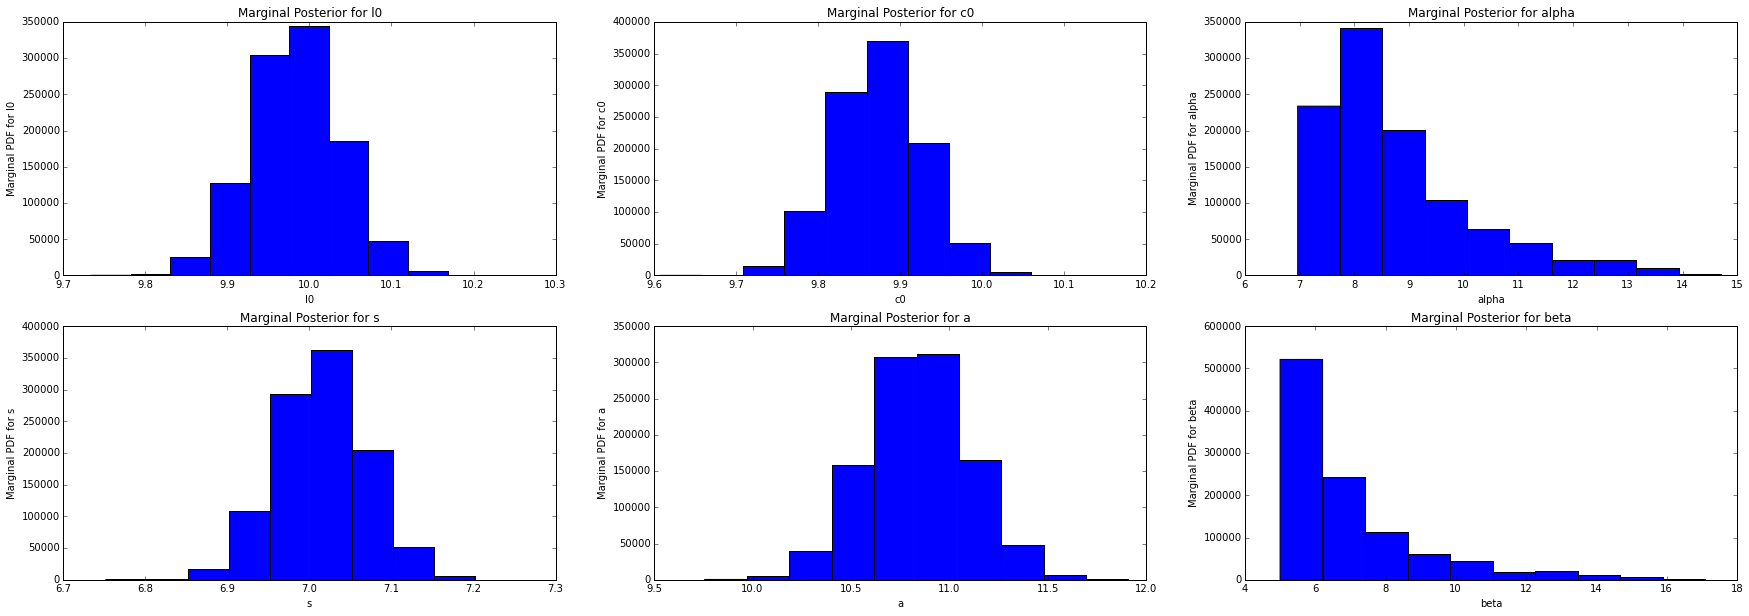

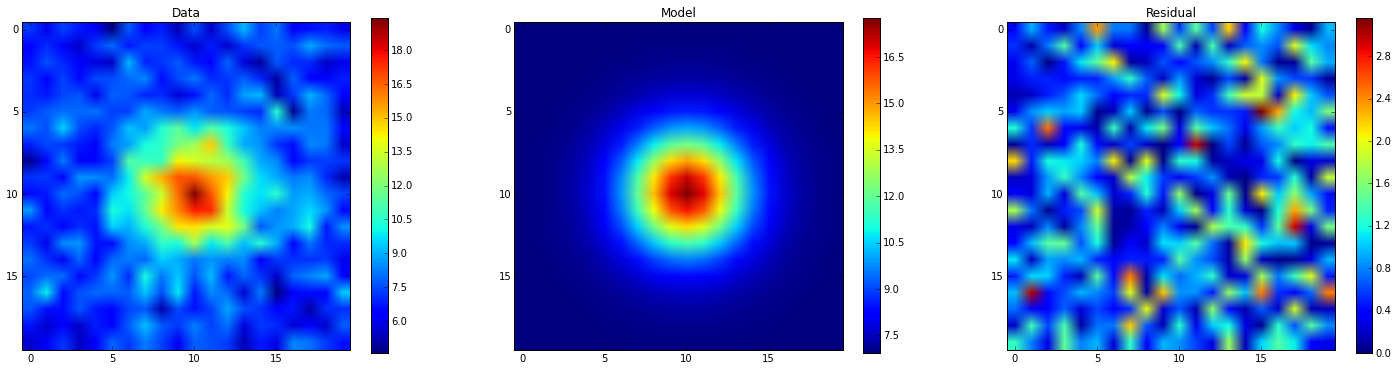

In [59]:
from matplotlib import pyplot as plt

print "Real values: C0= %d,  L0= %d , alpha=%d, beta=%d, amp=%d , sky = %d" %(l0 , c0, alphaa, beta, amp , s)
print "Estimate C0= %.2f,  L0= %.2f , alpha=%.2f, beta=%.2f, amp=%.2f , sky = %.2f" %(np.mean(params[nb:,0]),
    np.mean(params[nb:,1]), np.mean(params[nb:,2]) 
    ,np.mean(params[nb:,3])
    ,np.mean(params[nb:,4])
    ,np.mean(params[nb:,5]))
print "acceptance rate = %.2f %%" %(numaccept / np.float(nrep) *100)

plt.figure(figsize=(30,10))
plt.subplot(2,3,1)
plt.hist(params[nb:,0])
plt.title("Gaussian Histogram")
plt.title('Marginal Posterior for l0')
plt.ylabel('Marginal PDF for l0')
plt.xlabel('l0')

plt.subplot(2,3,2)
plt.hist(params[nb:,1])
plt.title("Gaussian Histogram")
plt.title('Marginal Posterior for c0')
plt.ylabel('Marginal PDF for c0')
plt.xlabel('c0')

plt.subplot(2,3,5)
plt.hist(params[nb:,4])
plt.title("Gaussian Histogram")
plt.title('Marginal Posterior for a')
plt.ylabel('Marginal PDF for a')
plt.xlabel('a')

plt.subplot(2,3,4)
plt.hist(params[nb:,5])
plt.title("Gaussian Histogram")
plt.title('Marginal Posterior for s')
plt.ylabel('Marginal PDF for s')
plt.xlabel('s')

plt.subplot(2,3,3)
plt.hist(params[nb:,2])
plt.title("Gaussian Histogram")
plt.title('Marginal Posterior for alpha')
plt.ylabel('Marginal PDF for alpha')
plt.xlabel('alpha')

plt.subplot(2,3,6)
plt.hist(params[nb:,3])
plt.title("Gaussian Histogram")
plt.title('Marginal Posterior for beta')
plt.ylabel('Marginal PDF for beta')
plt.xlabel('beta')

#Model with values of sky and amplitude found:
gfitopt = np.mean(params[nb:,3]) + models.Moffat2D.evaluate(Col,Lig,amplitude=np.mean(params[nb:,4]), x_0=np.mean(params[nb:,1]), y_0=np.mean(params[nb:,0]), gamma=np.mean(params[nb:,2]), alpha=np.mean(params[nb:,3]))
# Plot the data with the best-fit model
plt.figure(figsize=(25,6))
plt.subplot(1,3,1)
plt.imshow(data)
plt.colorbar()
plt.title("Data")
plt.subplot(1,3,2)
plt.imshow(gfitopt)
plt.colorbar()
plt.title("Model")
plt.subplot(1,3,3)
plt.imshow(np.abs(- data + gfitopt))
plt.colorbar()
plt.title("Residual")
plt.show()

In [58]:
numaccept / np.float(nrep)

0.12331238095238095

References:

https://theoreticalecology.wordpress.com/2010/09/17/metropolis-hastings-mcmc-in-r/

## Optimize with Cython

In [49]:
%load_ext Cython

In [50]:
%%cython   -lgsl -lgslcblas 
cimport cython
#To use the gnu lirbrary
import numpy as np
cimport numpy as np
from cython_gsl cimport *
from astropy.modeling import models, fitting
from numpy import linalg as LA
from libc.math cimport log

#------------#
#-Parameters:
#------------#
#Grid
L= 20 ; C = 20;
Col, Lig = np.mgrid[:C, :L]
#Moffat
a=1; l0 =10; c0=10; beta = 2; alphaa =4;
#Noise Gaussian
sigma=1 #Standard Deviation
noise = np.random.normal(0, sigma, Col.shape)
#Sky
s=6.8
#amplitude star
amp=12.54

#------#
#data
#------#
# Generate PSF with astropy.modeling
g = models.Moffat2D.evaluate(Col,Lig,amplitude=a, x_0=c0, y_0=l0, gamma=alphaa, alpha=beta)

#Generate Data model to Use
data = s + amp * g + noise

#Data in one dimension
d = np.ravel(data) #from top to bottom. The first 20 element are c_(0-N) and l0.

cdef float like( np.ndarray param):
##Know parameters:
    #Moffat
    cdef int L= 20 ; 
    cdef int C = 20;
    Col, Lig = np.mgrid[:C, :L]
#Parameters to Estimate:
#[l0, c0, alpha, beta, a, s] 
    dd = models.Moffat2D.evaluate(Col,Lig,amplitude=param[4], x_0=param[1], y_0=param[0], gamma=param[2], alpha=param[3])
    gmodel2= np.ravel(dd)
    result = (d - (param[5] + gmodel2 )) #**2
    result = LA.norm(result)**2    #np.sum
    return result

#Initialize
cdef float sigmamcmc = .2
cdef gsl_rng *r = gsl_rng_alloc(gsl_rng_mt19937)
cdef Py_ssize_t i

#Start loop
cpdef np.ndarray mcmc( int nrep):
    cdef float u
    cdef int numaccept = 0
    cdef np.ndarray params = np.ones([nrep, 6], dtype=np.float64)
    cdef gsl_rng *r = gsl_rng_alloc(gsl_rng_mt19937)
    params[0] = [11,1,1,1,1,1]
    for i in range(nrep-1):
        u = np.random.rand()
        paramstemp = [gsl_ran_gaussian(r, sigmamcmc ) + params[i,0]    
                 ,gsl_ran_gaussian(r, sigmamcmc ) + params[i,1]  
                 ,gsl_ran_gaussian(r, sigmamcmc ) + params[i,2]  
                 ,gsl_ran_gaussian(r, sigmamcmc ) + params[i,3]  
                 ,gsl_ran_gaussian(r, sigmamcmc ) + params[i,4]  
                 ,gsl_ran_gaussian(r, sigmamcmc ) + params[i,5]]  
#    
        posteriorlogold = - like(params[i]) #+priorlog(params[i])
        posteriorlognew = - like(np.array(paramstemp)) #+ priorlog(paramstemp
        print params[i]
# %%!
    if log(u) < (posteriorlognew - posteriorlogold):
        params[i+1] = paramstemp
        numaccept = numaccept +1
    else:
        params[i+1] = params[i]

    
    return params


In [ ]:
params2 = mcmc(100000)
nb=500
print "Real values: C0= %d,  L0= %d , alpha=%d, beta=%d, amp=%d , sky = %d" %(l0 , c0, alphaa, beta, amp , s)
print "Estimate C0= %.2f,  L0= %.2f , alpha=%.2f, beta=%.2f, amp=%.2f , sky = %.2f" %(np.mean(params2[nb:,0]),
    np.mean(params2[nb:,1]), np.mean(params2[nb:,2]) 
    ,np.mean(params2[nb:,3])
    ,np.mean(params2[nb:,4])
    ,np.mean(params2[nb:,5]))
print "acceptance rate = %.2f %%" %(numaccept / np.float(nrep) *100)

[ 11.   1.   1.   1.   1.   1.]
[ 1.  1.  1.  1.  1.  1.]
[ 1.  1.  1.  1.  1.  1.]
[ 1.  1.  1.  1.  1.  1.]
[ 1.  1.  1.  1.  1.  1.]
[ 1.  1.  1.  1.  1.  1.]
[ 1.  1.  1.  1.  1.  1.]
[ 1.  1.  1.  1.  1.  1.]
[ 1.  1.  1.  1.  1.  1.]
[ 1.  1.  1.  1.  1.  1.]
[ 1.  1.  1.  1.  1.  1.]
[ 1.  1.  1.  1.  1.  1.]
[ 1.  1.  1.  1.  1.  1.]
[ 1.  1.  1.  1.  1.  1.]
[ 1.  1.  1.  1.  1.  1.]
[ 1.  1.  1.  1.  1.  1.]
[ 1.  1.  1.  1.  1.  1.]
[ 1.  1.  1.  1.  1.  1.]
[ 1.  1.  1.  1.  1.  1.]
[ 1.  1.  1.  1.  1.  1.]
[ 1.  1.  1.  1.  1.  1.]
[ 1.  1.  1.  1.  1.  1.]
[ 1.  1.  1.  1.  1.  1.]
[ 1.  1.  1.  1.  1.  1.]
[ 1.  1.  1.  1.  1.  1.]
[ 1.  1.  1.  1.  1.  1.]
[ 1.  1.  1.  1.  1.  1.]
[ 1.  1.  1.  1.  1.  1.]
[ 1.  1.  1.  1.  1.  1.]
[ 1.  1.  1.  1.  1.  1.]
[ 1.  1.  1.  1.  1.  1.]
[ 1.  1.  1.  1.  1.  1.]
[ 1.  1.  1.  1.  1.  1.]
[ 1.  1.  1.  1.  1.  1.]
[ 1.  1.  1.  1.  1.  1.]
[ 1.  1.  1.  1.  1.  1.]
[ 1.  1.  1.  1.  1.  1.]
[ 1.  1.  1.  1.  1.  1.]
[ 1.  

In [ ]:
%%cython   -lgsl -lgslcblas 
cimport cython
#To use the gnu lirbrary
import numpy as np
cimport numpy as np
from cython_gsl cimport *

def gibbs(int N=2000000):
    cdef: 
        double x = 0
        double y = 0
        Py_ssize_t i
        np.ndarray[np.float64_t, ndim=2] samples = np.empty((N, 2), dtype=np.float64)
    cdef gsl_rng *r = gsl_rng_alloc(gsl_rng_mt19937)

    for i in range(N):
            x = np.random.normal(4, 5, 1)[0]
            y = gsl_ran_gaussian(r, 5 ) +4
            samples[i, 0] = x
            samples[i, 1] = y
    return samples

In [286]:
prueba = gibbs()
numm=prueba[:,0]
gsla = prueba[:,1]
print np.mean(numm)
print np.mean(gsla)
print np.var(numm)
print np.var(gsla)

4.0008136812
4.00261695102
24.9902351388
24.9899371038
